# Importing useful libraries 

In [191]:
import pandas as pd # For dataframe related tasks
import numpy as np # For numerical related tasks

from collections import Counter # For counting 

# For natural language related tasks
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

import warnings

warnings.filterwarnings('ignore')

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# For model building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

# For model saving
import pickle

[nltk_data] Downloading package stopwords to /home/micky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/micky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data fetching

In [21]:
# Reading the data

df = pd.read_csv('../data/spam.csv',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data Cleaning

In [22]:
# Let us drop the last 3 columns

del_columns = ['Unnamed: 2','Unnamed: 3','Unnamed: 4']
df = df.drop(columns = del_columns)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [23]:
# Now let us change the column names

df = df.rename(columns = {
                        'v1':'target',
                        'v2':'message'    
                         })
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [24]:
# Let us see how many rows and columns our dataset has

df.shape

(5572, 2)

In [25]:
# Let us see info of our dataset

df.describe()

,target,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [27]:
# Let us change the ham,spam into 0,1

df['target'] = df['target'].apply(lambda x: 0 if x == 'ham' else 1)
df.head(5)

,target,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [28]:
# Let us see if there are any missing values

df.isna().sum()

target     0
message    0
dtype: int64

In [30]:
# Let us check if there are any duplicates

df.duplicated().sum()

403

In [31]:
# Let us drop these duplicates

df = df.drop_duplicates(keep = 'first')
df.shape

(5169, 2)

# EDA

In [34]:
# Let us see if our data is highly skewed or not

df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

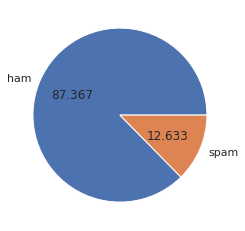

In [73]:
'''
As we can see from the above the data is skewed
So it is better not to do Machine Learning without 
doing some adjustments

Let us see the skewness using pie chart
'''

plt.pie(df['target'].value_counts(),
       labels = ['ham','spam'],
       autopct='%.3f'
       )
plt.savefig('../charts/pie_chart_of_spam_ham.png')
plt.show()

In [51]:
# Let us create a new column containing number of characters

df['num_char'] = df['message'].apply(len)
df.head()

,target,message,num_char
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [52]:
# Let us create a new column containing number of words

df['num_words'] = df['message'].apply(lambda x: len(nltk.word_tokenize(x)))
df.head()

,target,message,num_char,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [53]:
# Let us create a new column containing number of sentences

df['num_sent'] = df['message'].apply(lambda x: len(nltk.sent_tokenize(x)))
df.head()

,target,message,num_char,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [55]:
# Let us see how these columns are distributed

df[['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.453279,1.947185
std,58.236293,13.324793,1.362406
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,28.000000


In [62]:
# Now let us specifically see for the ham messages

df[df['target'] == 0][['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.120903,1.799601
std,56.358207,13.493725,1.278465
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [63]:
# Now let us specifically see for the spam messages

df[df['target'] == 1][['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


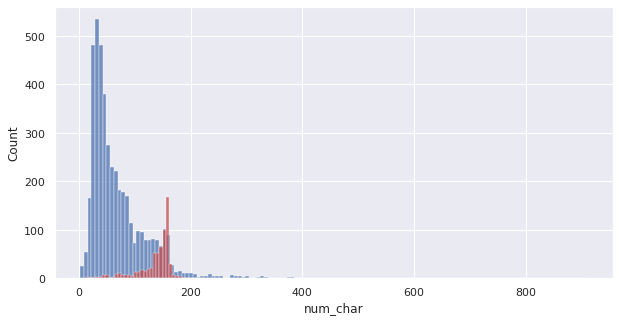

In [72]:
'''
From the above we can clearly see that spam messages
have more words and sentences than the normal ones.

Let us use a histogram plot to see more
'''

sns.set()
plt.figure(figsize=(10,5))
sns.histplot(df[df['target'] == 0]['num_char'])
sns.histplot(df[df['target'] == 1]['num_char'],color='r')
plt.savefig('../charts/hist_plot_of_spam_ham.png')
plt.show()

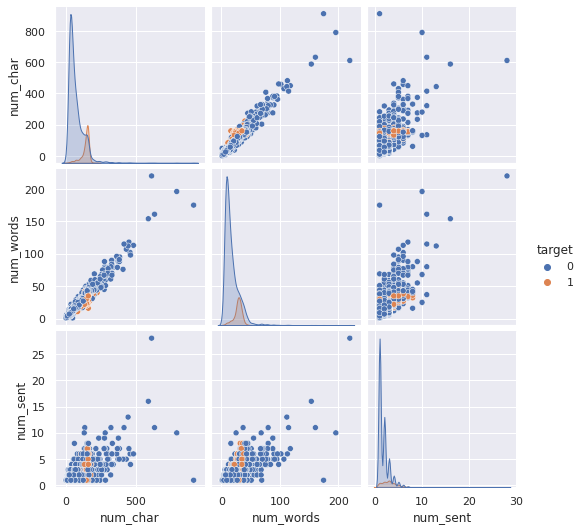

In [75]:
# Let us see plot the whole column relation 


sns.pairplot(df,hue='target')
plt.savefig('../charts/over_all_view.png')
plt.show()

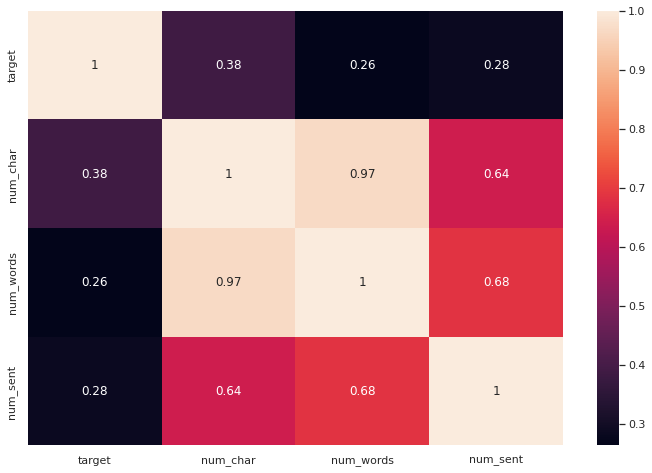

In [85]:
# Let us now try to plot the correlation matrix

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True)
plt.savefig('../charts/correlation_plot.png')
plt.show()

# Data Preprocessing

In [123]:
'''
Let us create a function that:

1. Changes into a lower case
2. Remove all the non-alpha numeric values
3. Remove all the punctuations
'''

def transform_text(message):
    
    # Changing each word into lower case
    message = message.lower()
    
    # Creating a token list
    tokens = []
    message = nltk.word_tokenize(message)
    
    # Creating the stemmer object
    ps = PorterStemmer()  
    
    # Itterating through all the message tokens
    for word in message:
        
        # Removing all the non-alphanumeric and stop words
        if word.isalnum() and word not in stopwords.words('english'):
            
            # Stemming all the words(example: changing 'words' --> 'word')
            tokens.append(ps.stem(word))
    
    # Returning a string of cleaned tokens
    return ' '.join(tokens)

# Let us display how the function works by giving a simple statement

transform_text('Python is the best programmig language for students  :):):)!!!')

'python best programmig languag student'

In [124]:
# Now let us apply the above function on our dataset and create a new column

df['transformed_message'] = df['message'].apply(transform_text)
df.head()

,target,message,num_char,num_words,num_sent,transformed_message
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [141]:
# Let us initialize the word cloud visualization object

wc = WordCloud(width=500,
              height=500,
              min_font_size=10,
              background_color='white'               
              )

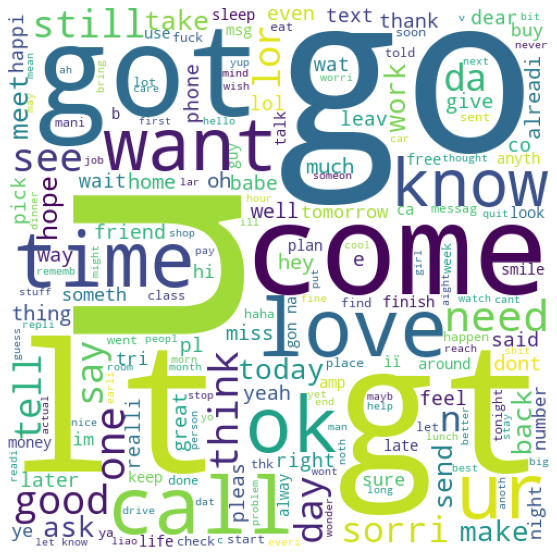

In [146]:
# Let us see the word cloud view for the ham message

ham_word_cloud = wc.generate(df[df['target'] == 0 ]['transformed_message'].str.cat(sep = ' '))
plt.figure(figsize=(10,10))
plt.imshow(ham_word_cloud)
plt.savefig('../charts/ham_word_cloud.png')
plt.axis('off')
plt.show()

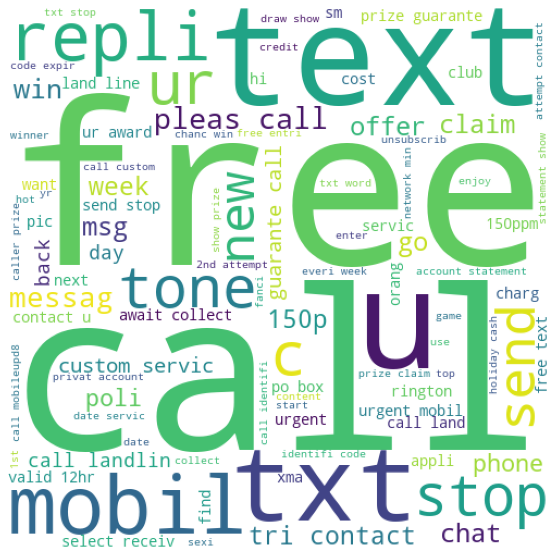

In [147]:
# Let us see the word cloud view for the spam message

spam_word_cloud = wc.generate(df[df['target'] == 1 ]['transformed_message'].str.cat(sep = ' '))
plt.figure(figsize=(10,10))
plt.imshow(spam_word_cloud)
plt.savefig('../charts/spam_word_cloud.png')
plt.axis('off')
plt.show()

In [152]:
# Let us create a list of words in the spam messages and see their occurance

spam_word_list = []
for message in df[df['target'] == 1]['transformed_message'].tolist():
    for word in message.split():
        spam_word_list.append(word)

Counter(spam_word_list).most_common(10)

[('call', 320),
 ('free', 191),
 ('2', 155),
 ('txt', 141),
 ('text', 122),
 ('u', 119),
 ('ur', 119),
 ('mobil', 114),
 ('stop', 104),
 ('repli', 103)]

In [168]:
# Let us do the same for the ham messages

ham_word_list = []
for message in df[df['target'] == 0]['transformed_message'].tolist():
    for word in message.split():
        ham_word_list.append(word)

Counter(ham_word_list).most_common(10)

[('u', 883),
 ('go', 404),
 ('get', 349),
 ('gt', 288),
 ('lt', 287),
 ('2', 284),
 ('come', 275),
 ('got', 236),
 ('know', 236),
 ('like', 234)]

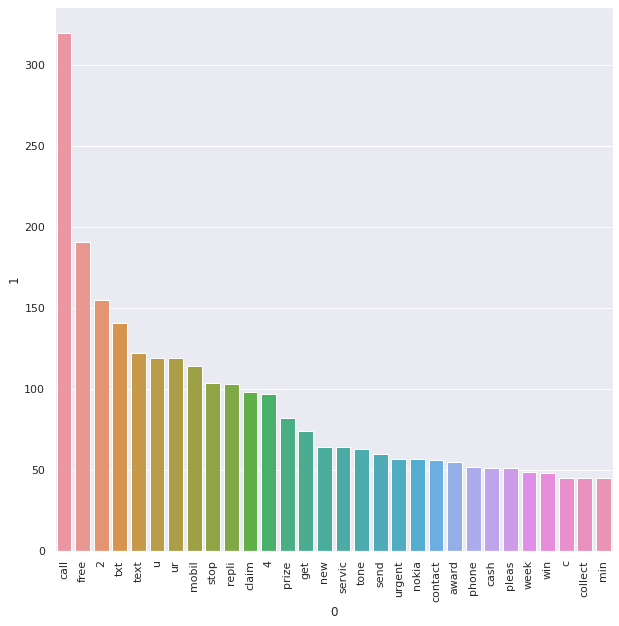

In [167]:
# Let us try to use bar plot and visualize the top 30 common words

spam_df = pd.DataFrame(Counter(spam_word_list).most_common(30))

plt.figure(figsize=(10,10))
sns.barplot(spam_df,
            x = spam_df[0],
            y = spam_df[1]
           )
plt.xticks(rotation='vertical')
plt.savefig('../charts/bar_plot_spam_words.png')
plt.show()

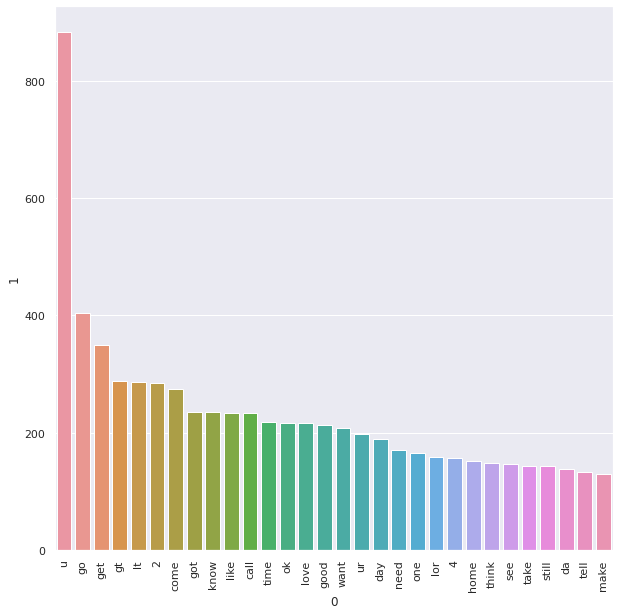

In [170]:
# Let us visualize for the ham messages too

ham_df = pd.DataFrame(Counter(ham_word_list).most_common(30))

plt.figure(figsize=(10,10))
sns.barplot(ham_df,
            x = ham_df[0],
            y = ham_df[1]
           )
plt.xticks(rotation='vertical')
plt.savefig('../charts/bar_plot_ham_words.png')
plt.show()

# Model building

In [192]:
# Let us change the message into vector 

tf = TfidfVectorizer(max_features=3000)
X = tf.fit_transform(df['transformed_message']).toarray()
X.shape

(5169, 3000)

In [193]:
# Now let us also create a target variable y

y = df['target'].values
y.shape

(5169,)

In [194]:
# Train test spliting

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                stratify=y,
                                                test_size=0.2,
                                                random_state=1
                                                )

In [195]:
# Let us initialize multiple models

gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [196]:
# Let us train each model

gnb.fit(X_train,y_train)
mnb.fit(X_train,y_train)
bnb.fit(X_train,y_train)

BernoulliNB()

# Model evaluation

In [197]:
# Let us see the accuracy of each model

for model in ['Gaussian','Multinomial','Bernoulli']:
    
    if model == 'Gaussian':
        print('=========================')
        print("The accuracy scores of gnb")
        pred = gnb.predict(X_test)
        print(accuracy_score(y_test,pred))
        print(confusion_matrix(y_test,pred))
        print(precision_score(y_test,pred))
    
    elif model == 'Multinomial':
        print('=========================')
        print("The accuracy scores of mnb")
        pred = mnb.predict(X_test)
        print(accuracy_score(y_test,pred))
        print(confusion_matrix(y_test,pred))
        print(precision_score(y_test,pred))
    
    if model == 'Bernoulli':
        print('=========================')
        print("The accuracy scores of bnb")
        pred = bnb.predict(X_test)
        print(accuracy_score(y_test,pred))
        print(confusion_matrix(y_test,pred))
        print(precision_score(y_test,pred))

The accuracy scores of gnb
0.8655705996131529
[[779 124]
 [ 15 116]]
0.48333333333333334
The accuracy scores of mnb
0.9796905222437138
[[902   1]
 [ 20 111]]
0.9910714285714286
The accuracy scores of bnb
0.9835589941972921
[[901   2]
 [ 15 116]]
0.9830508474576272


# Model saving

In [198]:
# From the above accuracy score we can select the multinomialNB
# Let us save this model and the vector

with open('../models/spam_classifier_model.h5','wb') as f:
    pickle.dump(mnb,f)
    
with open('../models/vectorizer.h5','wb') as f:
    pickle.dump(tf,f)